### Overview
The kernel goes through:
1. preprocessing steps to load data
2. quick visualization of the color space
3. training a simple CNN
4. applying the model to the test data
5. creating the RLE test data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV files I/O (eg. pd.read_csv())
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join("..", "data")
stage_label = "stage1"

### Read in the labels

In [2]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir, "{}_train_labels/{}_train_labels.csv".format(stage_label, stage_label)))
train_labels["EncodedPixels"] = train_labels["EncodedPixels"].map(lambda ep: [int(x) for x in ep.split(" ")])
train_labels.sample(3)

,ImageId,EncodedPixels
7735,4185b9369fc8bdcc7e7c68f2129b9a7442237cd0f836a4...,"[60804, 4, 61059, 6, 61315, 7, 61570, 9, 61826..."
6017,308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f4...,"[10955, 3, 11210, 5, 11465, 6, 11720, 7, 11974..."
1827,0ea221716cf13710214dcd331a61cea48308c3940df1d2...,"[14561, 1, 15081, 2, 15601, 2, 16121, 3, 16641..."


In [3]:
train_labels.shape

(29461, 2)

### Load in all the images

Here we load in the images and process the paths so we have the appropriate information for each image

In [4]:
all_images = glob(os.path.join(dsb_data_dir, "stage1_*", "*", "*", "*"))

In [5]:
len(all_images)

30196

In [6]:
img_df = pd.DataFrame({"path": all_images})

In [7]:
img_df.iloc[1]["path"]
# print(img_df.iloc['28008'])

'../data/stage1_train/e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243/masks/8b41b3cbc98d9c7f29f31b5a06ad3d2cf9453395f9e8991652d0026c1d998340.png'

In [8]:
img_id = lambda in_path: in_path.split("/")[-3]
img_type = lambda in_path: in_path.split("/")[-2]
img_group = lambda in_path: in_path.split("/")[-4].split("_")[1]
img_stage = lambda in_path: in_path.split("/")[-4].split("_")[0]
img_df["ImageId"] = img_df["path"].map(img_id)
img_df["ImageType"] = img_df["path"].map(img_type)
img_df["ImageGroup"] = img_df["path"].map(img_group)
img_df["Stage"] = img_df["path"].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,ImageGroup,Stage
19338,../data/stage1_train/709e094e39629a9ca21e187f0...,709e094e39629a9ca21e187f007b331074694e443db402...,masks,train,stage1
7802,../data/stage1_train/8efed2e62c919e6d70a2ab548...,8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177...,masks,train,stage1


In [9]:
img_df["ImageGroup"].unique()

array(['train', 'test'], dtype=object)

In [10]:
img_df["ImageType"].unique()

array(['masks', 'images'], dtype=object)

### Create training Data
- Here we make training data and load all the images into the dataframe. We take a simplification here of grouping all the regions together rather than keeping them distinct

In [11]:
%%time
train_df = img_df.query("ImageGroup=='train'")
train_rows = []
group_cols = ["Stage", "ImageId"]
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
#     print(c_row)
    c_row["masks"] = n_rows.query("ImageType == 'masks'")["path"].values.tolist()
    c_row["images"] = n_rows.query("ImageType == 'images'")["path"].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df["images"] = train_img_df["images"].map(read_and_stack).map(lambda x: x[:, :, :IMG_CHANNELS])
train_img_df["masks"] = train_img_df["masks"].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 36.9 s, sys: 4.7 s, total: 41.6 s
Wall time: 45.2 s


In [12]:
train_img_df.iloc[1]

ImageId    003cee89357d9fe13516167fd67b609a164651b2193458...
Stage                                                 stage1
images     [[[0.0196078431372549, 0.0196078431372549, 0.0...
masks      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 1, dtype: object

### Show a few images
Here we show a few images of the cells where we see there is a mixture of brightfield and fluroescence which will probably make using a single segmentation algorithm difficult

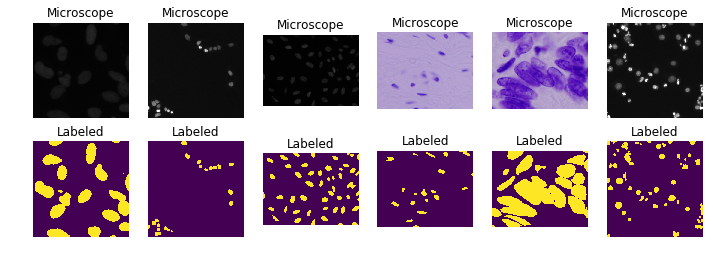

In [13]:
n_img = 6
fig, m_axis = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), m_axis.T):
#     print(c_row)
    c_im.imshow(c_row["images"])
    c_im.axis("off")
    c_im.set_title("Microscope")
    
    c_lab.imshow(c_row["masks"])
    c_lab.axis("off")
    c_lab.set_title("Labeled")

In [14]:
for key, series in train_img_df.sample(6).iterrows():
    print(series)
    series["images"]
    break

ImageId    f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8...
Stage                                                 stage1
images     [[[0.00784313725490196, 0.00784313725490196, 0...
masks      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 636, dtype: object


### Looking at the intensity distribution
Here we look briefly at the distribution and see a few groups forming, they should probably be handled seperately

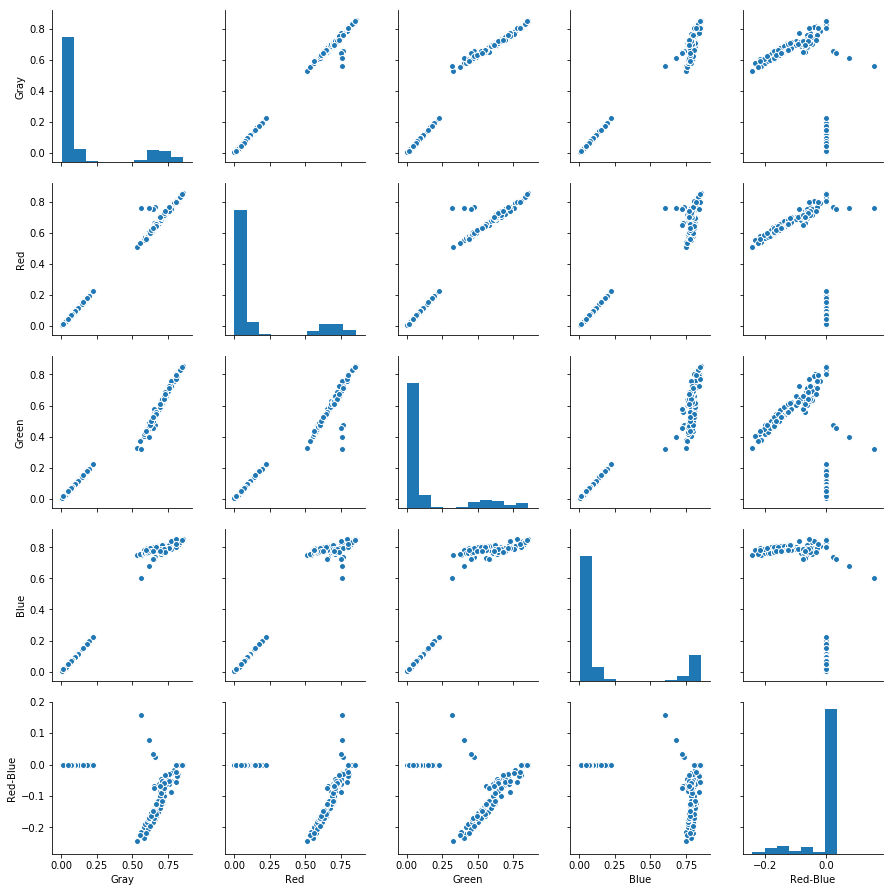

In [15]:
train_img_df["Red"] = train_img_df["images"].map(lambda x: np.mean(x[:, :, 0]))
train_img_df["Green"] = train_img_df["images"].map(lambda x: np.mean(x[:, :, 1]))
train_img_df["Blue"] = train_img_df["images"].map(lambda x: np.mean(x[:, :, 2]))
train_img_df["Gray"] = train_img_df["images"].map(lambda x: np.mean(x))
train_img_df["Red-Blue"] = train_img_df["images"].map(lambda x: np.mean(x[:, :, 0] - x[:, :, 2]))
sns.pairplot(train_img_df[["Gray", "Red", "Green", "Blue", "Red-Blue"]])


### Check Dimensions
Here we show the dimensions of the data to see the variety in the input images

In [16]:
train_img_df["images"].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

###### Making a simple CNN
Here we make a very simple CNN just to get a quick idea of how well it works. For this we use a batch normalization to normalize the inputs. We cheat a bit with the padding to keep problems simple

In [17]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda

Using TensorFlow backend.


In [18]:
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), name="NormalizeInput"))
simple_cnn.add(Conv2D(8, kernel_size=(3, 3), padding="same"))
simple_cnn.add(Conv2D(8, kernel_size=(3, 3), padding="same"))
# use dilations to get slightly larger field of view
simple_cnn.add(Conv2D(16, kernel_size=(3, 3), dilation_rate=2, padding="same"))
simple_cnn.add(Conv2D(16, kernel_size=(3, 3), dilation_rate=2, padding="same"))
simple_cnn.add(Conv2D(32, kernel_size=(3, 3), dilation_rate=3, padding="same"))

#the final processing
simple_cnn.add(Conv2D(16, kernel_size=(1, 1), padding="same"))
simple_cnn.add(Conv2D(1, kernel_size=(1, 1), padding="same", activation="sigmoid"))
simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 16)    528       
__________

### Loss
Since we are being evaluated with intersection over union we can use the inverse of the DICE score as the loss funciton to optimize

In [19]:
from keras import backend as K
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
simple_cnn.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef, "acc", "mse"])

### Simple Training

Here we run a simple training, with each image being it's own batch (not a very good idea) but it keeps the code simple

In [20]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row["images"], 0), np.expand_dims(np.expand_dims(c_row["masks"], -1), 0)
            
simple_cnn.fit_generator(simple_gen(),
                        steps_per_epoch=train_img_df.shape[0],
                        epochs=3)

Epoch 1/3
670/670 [==============================] - 29s 43ms/step - loss: -0.6892 - dice_coef: 0.6892 - acc: 0.8745 - mean_squared_error: 0.1189
Epoch 2/3
670/670 [==============================] - 20s 30ms/step - loss: -0.7878 - dice_coef: 0.7878 - acc: 0.9267 - mean_squared_error: 0.0707
Epoch 3/3
670/670 [==============================] - 20s 30ms/step - loss: -0.7999 - dice_coef: 0.7999 - acc: 0.9285 - mean_squared_error: 0.0694


### Apply Model to Test
Here we apply model to the test data

In [21]:
%%time
test_df = img_df.query("ImageGroup=='test'")
test_rows = []
group_cols = ["Stage"]

CPU times: user 3.68 ms, sys: 0 ns, total: 3.68 ms
Wall time: 3.29 ms


In [22]:
test_df

,path,ImageId,ImageType,ImageGroup,Stage
30131,../data/stage1_test/df40099c6306ca1f47fcc8a62e...,df40099c6306ca1f47fcc8a62e2fa39486d4e223177afd...,images,test,stage1
30132,../data/stage1_test/9f17aea854db13015d19b34cb2...,9f17aea854db13015d19b34cb2022cfdeda44133323fcd...,images,test,stage1
30133,../data/stage1_test/648c8ffa496e1716017906d0bf...,648c8ffa496e1716017906d0bf135debfc93386ae86aa3...,images,test,stage1
30134,../data/stage1_test/a4816cc1fb76cb3c5e48118683...,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,images,test,stage1
30135,../data/stage1_test/44afae184c89e6ba55985b4d34...,44afae184c89e6ba55985b4d341acc1ae1e8b6ef963120...,images,test,stage1
30136,../data/stage1_test/1ef68e93964c2d9230100c1347...,1ef68e93964c2d9230100c1347c328f6385a7bc027879d...,images,test,stage1
30137,../data/stage1_test/7f4cbe0b36b5d09466476a7d4e...,7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4...,images,test,stage1
30138,../data/stage1_test/53df5150ee56253fe5bc91a923...,53df5150ee56253fe5bc91a9230d377bb21f1300f443ba...,images,test,stage1
30139,../data/stage1_test/519dc0d672d1c295fc69b629af...,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,images,test,stage1
30140,../data/stage1_test/f0d0ab13ff53adc3c4d57e95a5...,f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002...,images,test,stage1
